In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from typing import List
np.set_printoptions(threshold=np.inf)  

from fragment import *
from side import *
from sides_comparison import *
from utils import *
import global_values
from groups import *
from merge_groups_best_candidate import *

global_values.GRAD_SCORING = True
global_values.NN_SCORING = False

# prudent score
# global_values.IMAGE_TH = 0.2
# global_values.GROUP_TH = 0.08

#classic score
global_values.IMAGE_TH = 0.2
global_values.GROUP_TH = 0.08



In [2]:
image_path = "disney_puzzle/aladin.jpg" 
output_folder = "fragments"

global_values.COL_NR = 14
global_values.ROW_NR = 14
solution_path = f"solution/valid_comparisons_{global_values.COL_NR}_{global_values.ROW_NR}.txt"

fragments, tile_h, tile_w = divide_image(image_path, output_folder,solution_path, global_values.COL_NR, global_values.ROW_NR)
global_values.TILE_H = global_values.TILE_W = max(tile_h, tile_w)


fragment_rotation_dictionary = None


sides_comparisons = create_sides_comparisons(fragments,fragment_rotation_dictionary)
sides_comparisons = calculate_buddy_score(fragments,sides_comparisons)

sorted_sides_comparisons = sort_sides_comparisons(sides_comparisons)

n = len(fragments)
s = 4  
global_values.SYMMETRIC_COMPARISONS = [[[[None for _ in range(s)] for _ in range(s)] for _ in range(n)] for _ in range(n)]

for c in sides_comparisons:
    global_values.SYMMETRIC_COMPARISONS[c.side1.fragment_idx][c.side2.fragment_idx][c.side1.side_idx][c.side2.side_idx] = c
    symmetric_comp = SidesComparison(fragments, c.side2, c.side1, fragment_rotation_dictionary)
    global_values.SYMMETRIC_COMPARISONS[c.side2.fragment_idx][c.side1.fragment_idx][c.side2.side_idx][c.side1.side_idx] = symmetric_comp
    global_values.SYMMETRIC_COMPARISONS[c.side2.fragment_idx][c.side1.fragment_idx][c.side2.side_idx][c.side1.side_idx].buddy_score = c.buddy_score
    global_values.SYMMETRIC_COMPARISONS[c.side2.fragment_idx][c.side1.fragment_idx][c.side2.side_idx][c.side1.side_idx].prudent_score = c.prudent_score

    if c.buddy_score is None:
        print("buddy score none")

Rotations by fragment: 0)0.0, 1)0.0, 2)0.0, 3)0.0, 4)0.0, 5)0.0, 6)0.0, 7)0.0, 8)0.0, 9)0.0, 10)0.0, 11)0.0, 12)0.0, 13)0.0, 14)0.0, 15)0.0, 16)0.0, 17)0.0, 18)0.0, 19)0.0, 20)0.0, 21)0.0, 22)0.0, 23)0.0, 24)0.0, 25)0.0, 26)0.0, 27)0.0, 28)0.0, 29)0.0, 30)0.0, 31)0.0, 32)0.0, 33)0.0, 34)0.0, 35)0.0, 36)0.0, 37)0.0, 38)0.0, 39)0.0, 40)0.0, 41)0.0, 42)0.0, 43)0.0, 44)0.0, 45)0.0, 46)0.0, 47)0.0, 48)0.0, 49)0.0, 50)0.0, 51)0.0, 52)0.0, 53)0.0, 54)0.0, 55)0.0, 56)0.0, 57)0.0, 58)0.0, 59)0.0, 60)0.0, 61)0.0, 62)0.0, 63)0.0, 64)0.0, 65)0.0, 66)0.0, 67)0.0, 68)0.0, 69)0.0, 70)0.0, 71)0.0, 72)0.0, 73)0.0, 74)0.0, 75)0.0, 76)0.0, 77)0.0, 78)0.0, 79)0.0, 80)0.0, 81)0.0, 82)0.0, 83)0.0, 84)0.0, 85)0.0, 86)0.0, 87)0.0, 88)0.0, 89)0.0, 90)0.0, 91)0.0, 92)0.0, 93)0.0, 94)0.0, 95)0.0, 96)0.0, 97)0.0, 98)0.0, 99)0.0, 100)0.0, 101)0.0, 102)0.0, 103)0.0, 104)0.0, 105)0.0, 106)0.0, 107)0.0, 108)0.0, 109)0.0, 110)0.0, 111)0.0, 112)0.0, 113)0.0, 114)0.0, 115)0.0, 116)0.0, 117)0.0, 118)0.0, 119)0.0, 120)0.0

100%|██████████| 195/195 [00:22<00:00,  8.68it/s]


In [3]:
groups = []
fragment_idx_to_group_idx = [None for _ in fragments]

for fr_idx in range(len(fragments)):
    new_group = Group(fr_idx)
    groups.append(new_group)
    fragment_idx_to_group_idx[fr_idx] = fr_idx
print(fragment_idx_to_group_idx)



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195]


Sides Comp: Score=0.004102897530739548 Buddy_Score:1.0 Fragment_idx1=74, Side_idx1=1; fragment_idx2=75, side_idx2=3
Sides Comp: Score=0.004215488054334829 Buddy_Score:1.0 Fragment_idx1=126, Side_idx1=2; fragment_idx2=140, side_idx2=0
Sides Comp: Score=0.004893364605301729 Buddy_Score:1.0 Fragment_idx1=60, Side_idx1=1; fragment_idx2=61, side_idx2=3
Sides Comp: Score=0.005187220855783607 Buddy_Score:1.0 Fragment_idx1=33, Side_idx1=1; fragment_idx2=34, side_idx2=3
Sides Comp: Score=0.005188830488612024 Buddy_Score:1.0 Fragment_idx1=90, Side_idx1=1; fragment_idx2=91, side_idx2=3
Sides Comp: Score=0.005218850259465549 Buddy_Score:1.0 Fragment_idx1=48, Side_idx1=1; fragment_idx2=49, side_idx2=3
Sides Comp: Score=0.0055201594813448895 Buddy_Score:1.0 Fragment_idx1=80, Side_idx1=1; fragment_idx2=81, side_idx2=3
Sides Comp: Score=0.006239867937865567 Buddy_Score:1.0 Fragment_idx1=65, Side_idx1=2; fragment_idx2=79, side_idx2=0
Sides Comp: Score=0.006357283875453708 Buddy_Score:1.0 Fragment_idx1=

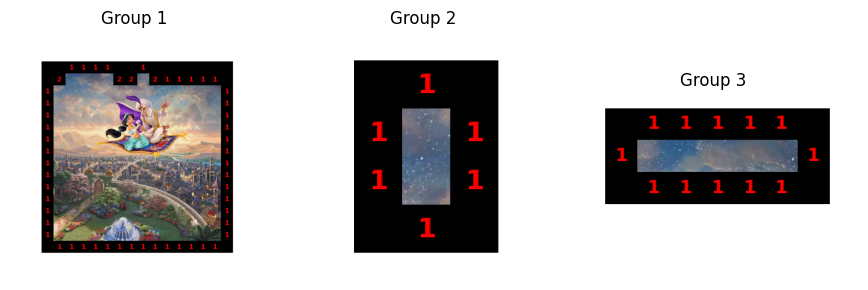

In [4]:
for comp in sorted_sides_comparisons:
    # if comp.prudent_score * comp.buddy_score < global_values.PRUDENT_X_BUDDY_TH_IMAGE:
    # if comp.score < 0.02:
    if comp.score < global_values.IMAGE_TH:
        
        anchor_fragment_idx = comp.side1.fragment_idx
        pasted_fragment_idx = comp.side2.fragment_idx
        anchor_group_idx = fragment_idx_to_group_idx[anchor_fragment_idx]
        pasted_group_idx = fragment_idx_to_group_idx[pasted_fragment_idx]

        if anchor_group_idx != pasted_group_idx:

            shifted_anchor_group, shifted_pasted_group, pasted_group_additional_rotation = simulate_merge_positions(fragments, comp, groups[anchor_group_idx], groups[pasted_group_idx])

            if does_merge_fit_within_bounds(shifted_anchor_group):
                if check_groups_shapes_for_merging(shifted_anchor_group, shifted_pasted_group):
                    # print(f"{comp}")

                    if check_all_group_matchings_scores(fragments, pasted_group_additional_rotation, shifted_anchor_group, shifted_pasted_group):    
                        groups[anchor_group_idx] = merge_groups(fragments, pasted_group_additional_rotation, shifted_anchor_group, shifted_pasted_group, fragment_idx_to_group_idx)
                        update_after_merge(groups, fragments, fragment_idx_to_group_idx, pasted_group_idx)
                        print(comp)

show_all_groups(groups, fragments, fragment_idx_to_group_idx, 1)

# for g in groups:
#     print(g.fragment_positions)


Merged group 1 and 0 with total score: 0.0870502468419421 using: Sides Comp: Score=0.07135874128598191 Buddy_Score:2.4520596660641445 Fragment_idx1=1, Side_idx1=3; fragment_idx2=0, side_idx2=1
Merged group 0 and 2 with total score: 0.11081443170514617 using: Sides Comp: Score=0.0910796408423844 Buddy_Score:3.574499311317237 Fragment_idx1=22, Side_idx1=0; fragment_idx2=8, side_idx2=2
Merged group 0 and 2 with total score: 0.10528415256001292 using: Sides Comp: Score=0.11549859959703568 Buddy_Score:5.486806813638346 Fragment_idx1=27, Side_idx1=0; fragment_idx2=13, side_idx2=2
Merged group 0 and 1 with total score: 0.22961889015301878 using: Sides Comp: Score=0.2623421609030417 Buddy_Score:12.002157088149485 Fragment_idx1=19, Side_idx1=0; fragment_idx2=5, side_idx2=1


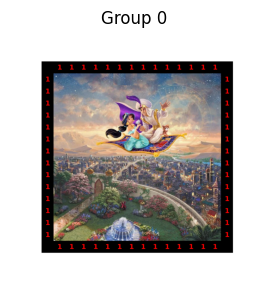

In [5]:
groups, fragments, fragment_idx_to_group_idx = solve_groups_safe(groups, fragments, fragment_idx_to_group_idx)
show_all_groups(groups, fragments, fragment_idx_to_group_idx, 0)



In [6]:
gt_comparisons = read_valid_comparisons(solution_path)



comparisons = []

for g in groups:
    n = len(g.grid)
    m = len(g.grid[0])

    for i in range(n):
        for j in range(m):
            fr1_idx = g.grid[i][j]
            if fr1_idx is not None:
                if j + 1 < m:
                    side1_idx = find_side_idx_of_orientation(fragments[fr1_idx].rotation, 1)
                    fr2_idx = g.grid[i][j + 1]
                    if fr2_idx is not None:
                        side2_idx = find_side_idx_of_orientation(fragments[fr2_idx].rotation,3)
                        comparisons.append((fr1_idx, fr2_idx, side1_idx, side2_idx))

                if i + 1 < n:
                    side1_idx = find_side_idx_of_orientation(fragments[fr1_idx].rotation, 2)
                    fr2_idx = g.grid[i + 1][j]
                    if fr2_idx is not None:
                        side2_idx = find_side_idx_of_orientation(fragments[fr2_idx].rotation, 0)
                        comparisons.append((fr1_idx, fr2_idx, side1_idx, side2_idx))

correct = 0
nr_of_comp = int((2 * 4 + 3 * ((global_values.COL_NR - 2) * 2 + (global_values.ROW_NR - 2)* 2) + 4 * ((global_values.COL_NR -2) * (global_values.COL_NR-2)))/2)
for s_comp in comparisons:
    for gt_comp in gt_comparisons:
        if s_comp == gt_comp:
            correct+=1
        if s_comp[0] == gt_comp[1] and s_comp[1] == gt_comp[0] and s_comp[2] == gt_comp[3] and s_comp[3] == gt_comp[2]:
            correct+=1

accuracy = (correct/nr_of_comp) * 100
print(f"Accuracy of algorithm: {accuracy}%")

Accuracy of algorithm: 98.62637362637363%


In [7]:
# introducere problema imagini input output

# care e algolritmul (greedy)
# functia de potrivire
# siameza

# cum merge pe low level, simaza pe diferiti nr pixeli
# timp

# 9 iunie licenta
